<a href="https://colab.research.google.com/github/legion911/7code_Task1/blob/main/Another_copy_of_IMDB_Sentiment_analysis_(ROC_curve)(Working)_(Lemmatization)(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Sentiment Analysis</center></h1>
<h3><center>Sentiment analysis of IMDB movie reviews</center></h3>

The aim of the project is perform Sentiment analysis of the reviews submitted on IMDB. IMDB is an online database of information related to visual entertainments like movies, TV series etc. It is a popular medium for people to review and rate movies. IMDB ratings are considered as benchmark for success of multiple movies.<br>

The dataset contains 50000 reviews, 25000 of each sentiment - positive (1) and negative (0).

# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pickle
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df= pd.read_csv('movie_data.csv')
df.head(10)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
5,Leave it to Braik to put on a good show. Final...,1
6,Nathan Detroit (Frank Sinatra) is the manager ...,1
7,"To understand ""Crash Course"" in the right cont...",1
8,I've been impressed with Chavez's stance again...,1
9,This movie is directed by Renny Harlin the fin...,1


For the sentiment analysis, it is important to clean the text of the reviews. The following steps are performed in order to clean them,

   * Lower case
   * Remove punctuations
   * Remove paranthesis
   * Remove stop words
   
After cleaning, only the important words of the reviews that give insights to its sentiments remain.

# Text Pre-processing

In [ ]:
def preprocessing(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
    text = re.sub('[\W]+',' ',text.lower()) + ' '.join(emoticons).replace('-','')
    words = word_tokenize(text)
    text = ' '.join([word for word in words if word not in ENGLISH_STOP_WORDS])
    return text

df.review = df.review.apply(preprocessing)
df.head(5)

,review,sentiment
0,1974 teenager martha moxley maggie grace moves...,1
1,ok really like kris kristofferson usual easy g...,0
2,spoiler read think watching movie waste time w...,0
3,hi people seen wonderful movie im sure thet li...,1
4,recently bought dvd forgetting just hated movi...,0


To gain insight into the kind of words used for both the sentiments, wordclouds are created for each class of sentiment. The word cloud highlights the most common words, showing what words usually appear in a review of that kind of sentiment.<br>

The first one is a word cloud for all the positive sentiment reviews.

# WordCloud

(-0.5, 1199.5, 799.5, -0.5)

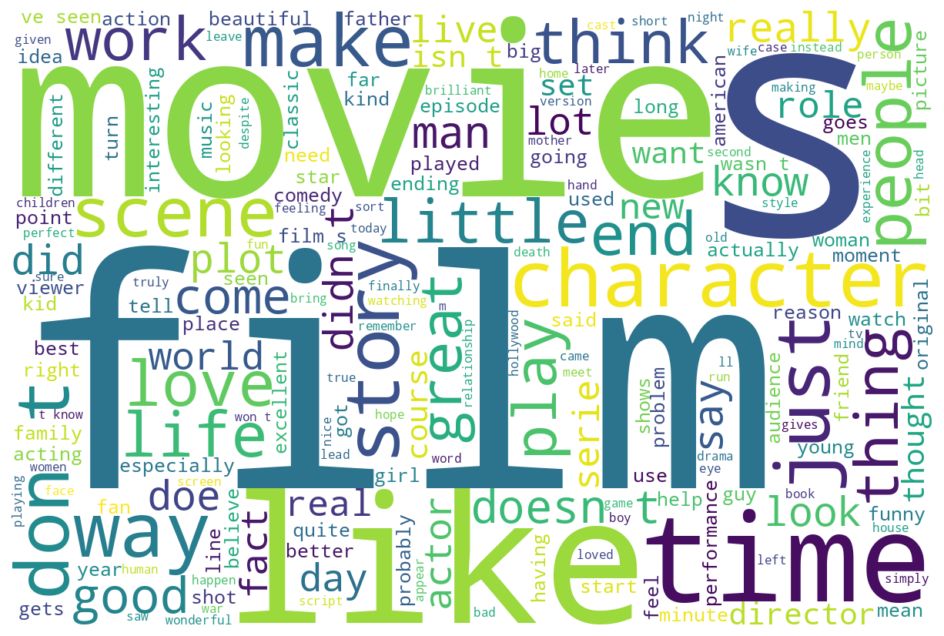

In [ ]:
text= ""

def get_all_text(t):
    global text
    text = text+t+" "

df.review[df.sentiment == 1].apply(get_all_text)

wordcloud = WordCloud(
    width= 1200,
    height= 800,
    stopwords= ENGLISH_STOP_WORDS,
    background_color= 'white'
).generate(text)

plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis('off')

The next plot is a wordcloud for all negative sentiment reviews.

(-0.5, 1199.5, 799.5, -0.5)

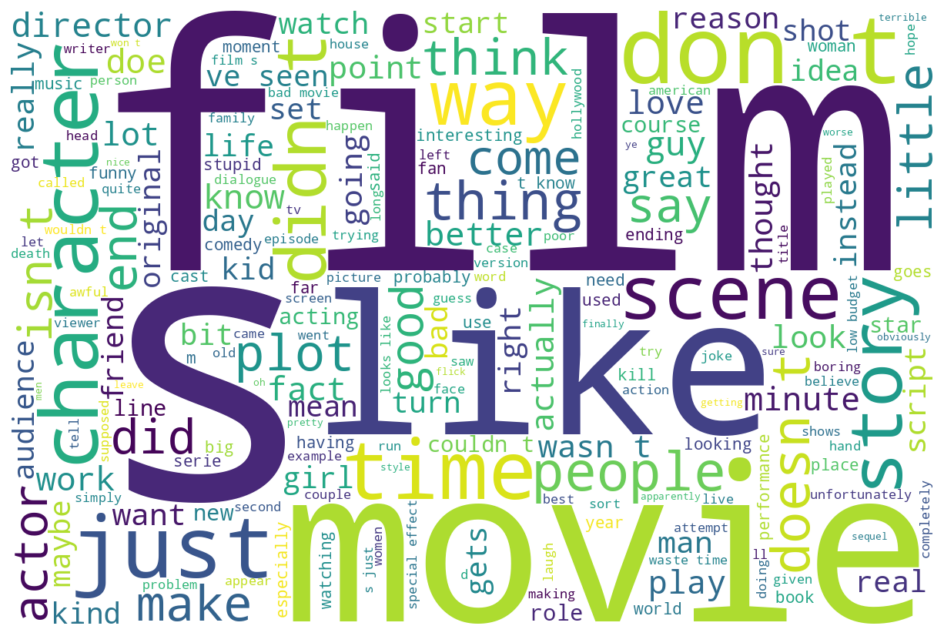

In [ ]:
text= ""

def get_all_text(t):
    global text
    text = text+t+" "

df.review[df.sentiment == 0].apply(get_all_text)

wordcloud = WordCloud(
    width= 1200,
    height= 800,
    stopwords= ENGLISH_STOP_WORDS,
    background_color= 'white'
).generate(text)

plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis('off')

The two plots show interesting results. Wordclouds show the most frequent words with the largest font and the font size decreases with frequency. Both the plots show similar words - film, movie, like, time, character etc. This goes to show that a word that appears so frequently in the reviews does not help in the classification of the review. This will be dealt with later on.

There can be multiple words in the reviews that are common to a stem, for example the words do, doing, done mean the same thing and are inflections of a common root form or stem - do. Treating such words as individuals can increase the dimensionality of the data. Thus a stemmer is used to reduce all words to its root. These stems are not dictionary format (as lemmas) and individually may not mean anything.

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# Create WordNetLemmatizer object

def lemm_text(text):
    wnl = WordNetLemmatizer()
    words = word_tokenize(text)
    return " ".join([wnl.lemmatize(word) for word in words])

df.review = df.review.apply(lemm_text)
df.head(5)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,review,sentiment
0,1974 teenager martha moxley maggie grace move ...,1
1,ok really like kris kristofferson usual easy g...,0
2,spoiler read think watching movie waste time w...,0
3,hi people seen wonderful movie im sure thet li...,1
4,recently bought dvd forgetting just hated movi...,0


In [ ]:
#def stem_text(text):
    #porter = PorterStemmer()
    #words = word_tokenize(text)
    #return " ".join([porter.stem(word) for word in words])

#df.review = df.review.apply(stem_text)
#df.head(5)

,review,sentiment
0,1974 teenag martha moxley maggi grace move hig...,1
1,ok realli like kri kristofferson usual easi go...,0
2,spoiler read think watch movi wast time way pl...,0
3,hi peopl seen wonder movi im sure thet like lo...,1
4,recent bought dvd forget just hate movi versio...,0


# Tf-Idf

As discussed earlier, most frequent words in the reviews do not actually help in classifying the review's sentiment. Firstly, each review is converted into a tokenized vector. For each word in the review a tfidf weight is calculated. The tfidf weight is large for rare words and small for common words, this way frequent words are given less importance in a review and rare words are given more.

In [ ]:
tfidf= TfidfVectorizer(use_idf= True, norm= 'l2', smooth_idf= True)

y= df.sentiment.values
X= tfidf.fit_transform(df.review)

The vectorized list of reviews become the input features and the sentiment column is the target. This is now split into train and test sets. The split is of 65:35.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size= 0.30,
    random_state= 1,
    shuffle= False
)

# **Logistic Regression**

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
scaling = MaxAbsScaler().fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

A **Logistic Regression** model is trained for this classification. For the c parameter tuning, LogisticRegressionCV is used, which will perform k-fold cross validation and grid search to find the optimal parameter based on accuracy.

In [ ]:
lr_model = LogisticRegressionCV(
    cv= 5,
    scoring= 'accuracy',
    max_iter= 300,
    n_jobs= -1,
    verbose= 3,
    random_state= 0
)
lr_model.fit(X_train,y_train)

pred = lr_model.predict(X_test)
print(classification_report(pred,y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


              precision    recall  f1-score   support

           0       0.89      0.90      0.89      7457
           1       0.90      0.89      0.89      7543

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000



In [ ]:
accuracy_train_set = lr_model.score(X_train, y_train)  #get accuracy on train set
accuracy_valid_set = lr_model.score(X_test, y_test)
print("Logistic Regression ML Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Logistic Regression ML Model, Accuracy (Valid Set) : ", accuracy_valid_set)

Logistic Regression ML Model, Accuracy (Train Set) :  0.9711714285714286
Logistic Regression ML Model, Accuracy (Valid Set) :  0.8931333333333333


The classification report shows good percentages, 89% for precision and recall and f1-score. The equal values for both mean that the classifier is good at predicting and understanding the classes.<br>



# **Support Vector Machine**

## feature scaling

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
scaling = MaxAbsScaler().fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [ ]:
from sklearn import svm
sv_model = svm.LinearSVC(random_state = 1)
sv_model.probability = True
sv_model.fit(X_train,y_train)
prob = sv_model._predict_proba_lr(X_train)
pred = sv_model.predict(X_test)
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      7475
           1       0.87      0.87      0.87      7525

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



In [ ]:
accuracy_train_set = sv_model.score(X_train, y_train)  #get accuracy on train set
accuracy_valid_set = sv_model.score(X_test, y_test)
print("Support vector ML Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Support Vector ML Model, Accuracy (Valid Set) : ", accuracy_valid_set)

Support vector ML Model, Accuracy (Train Set) :  0.9999714285714286
Support Vector ML Model, Accuracy (Valid Set) :  0.8692666666666666


The classification report of the SupporVector machine shows about the same results as the LogisticRegression model. The two models SupportVector and LogisticRegression are two good candidates.<br>



# Boosting (AdaBoost Classifier)

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
scaling = MaxAbsScaler().fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [ ]:
import time
tic = time.time()
#Train a Random Forest model
# Details: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import AdaBoostClassifier
estimators = 100
model_abc = AdaBoostClassifier(n_estimators=estimators) #The number of trees in the forest
model_abc.fit(X_train,  y_train)
toc = time.time()
y_pred_abc = model_abc.predict(X_test)
print(classification_report(y_pred_abc, y_test))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      7205
           1       0.84      0.81      0.83      7795

    accuracy                           0.82     15000
   macro avg       0.82      0.82      0.82     15000
weighted avg       0.82      0.82      0.82     15000



In [ ]:
accuracy_train_set = model_abc.score(X_train, y_train)  #get accuracy on train set
accuracy_valid_set = model_abc.score(X_test, y_test)  #get accuracy on valid set
print("Ada Boost CLassifier ML Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Ada Boost CLassifier ML Model, Accuracy (Valid Set) : ", accuracy_valid_set)
print("Time Taken: " + str(((toc-tic)*1000)) + " ms")

Ada Boost CLassifier ML Model, Accuracy (Train Set) :  0.8326571428571429
Ada Boost CLassifier ML Model, Accuracy (Valid Set) :  0.8226
Time Taken: 381434.85736846924 ms


# Bagging Classifier


In [ ]:
tic = time.time()
#Train a MLP classifier
# Details:https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html#sklearn.neighbors.RadiusNeighborsClassifierfrom sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
l2_norm = 2
l2_norm_inverse = 1/l2_norm
maximum_iterations=4000 #maximum number of iterations

model_bc = BaggingClassifier(estimator=LinearSVC(C=l2_norm_inverse,max_iter=maximum_iterations),
                             n_estimators=30,
                             random_state=0)

model_bc.fit(X_train, y_train)
toc = time.time()
y_pred_bg = model_bc.predict(X_test)
accuracy_train_set = model_bc.score(X_train, y_train)  #get accuracy on train set
accuracy_valid_set = model_bc.score(X_test, y_test)  #get accuracy on valid set
print("Bagging Classifier ML Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Bagging Classifier ML Model, Accuracy (Valid Set) : ", accuracy_valid_set)
print("Time Taken: " + str(((toc-tic)*1000)) + " ms")

Bagging Classifier ML Model, Accuracy (Train Set) :  0.9972
Bagging Classifier ML Model, Accuracy (Valid Set) :  0.8855333333333333
Time Taken: 66644.47355270386 ms


In [ ]:
print(classification_report(y_pred_bg, y_test))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      7505
           1       0.89      0.88      0.89      7495

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000



# Random forest

In [ ]:
rf_model = RandomForestClassifier(n_estimators= 200, n_jobs= -1, verbose= 1)
rf_model.fit(X_train, y_train)

pred = rf_model.predict(X_test)
print(classification_report(pred, y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  6.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s


              precision    recall  f1-score   support

           0       0.86      0.86      0.86      7532
           1       0.86      0.86      0.86      7468

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    2.6s finished


The RandomForest model achieves an 86% accuracy, precision, recall and f1-score. All the percentages are same and hence indicates that the model predicts and understands the classes well. The lesser accuracy as compared to the two models previously shows that RandomForest doesnot truly understand some cases as well as Logistic or SupportVector.<br>

The classification report shows all the models perform quite well and close to eachother. The ROC curve for each model is plotted below. It shows the AUC and TPR vs FPR of the model. The more the AUC the better the model performs.

In [ ]:
accuracy_train_set = rf_model.score(X_train, y_train)  #get accuracy on train set
accuracy_valid_set = rf_model.score(X_test, y_test)
print("Random Forests ML Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Random Forests ML Model, Accuracy (Valid Set) : ", accuracy_valid_set)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    5.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    5.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s


Random Forests ML Model, Accuracy (Train Set) :  1.0
Random Forests ML Model, Accuracy (Valid Set) :  0.8586666666666667


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    4.0s finished


# Naive Bayes

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
scaling = MaxAbsScaler().fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [ ]:
import time
tic = time.time()
#Train Naive Bayes Model
#More Details: https://scikit-learn.org/stable/modules/naive_bayes.html
from sklearn.naive_bayes import BernoulliNB #Gaussain assume fatures from normal distribution, Bernouli for boolean, multionomial for discreeet
nb_model = BernoulliNB()
nb_model.fit(X_train, y_train)
toc = time.time()
y_pred_nb = nb_model.predict(X_test)
print(classification_report(y_pred_nb, y_test))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      8080
           1       0.81      0.87      0.84      6920

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



In [ ]:
accuracy_train_set = nb_model.score(X_train, y_train)  #get accuracy on train set
accuracy_valid_set = nb_model.score(X_test, y_test)  #get accuracy on valid set
print("Naive Bayes Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Naive Bayes Model, Accuracy (Valid Set) : ", accuracy_valid_set)
print("Time Taken: " + str(((toc-tic)*1000)) + " ms")

Naive Bayes Model, Accuracy (Train Set) :  0.8978
Naive Bayes Model, Accuracy (Valid Set) :  0.8470666666666666
Time Taken: 81.48026466369629 ms


# SVM 2.0

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
scaling = MaxAbsScaler().fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [ ]:
tic = time.time()
#Train Support Vector Machine Model
#More Details: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
from sklearn.svm import LinearSVC
l2_norm = 25
l2_norm_inverse = 1/l2_norm
maximum_iterations=4000 #maximum number of iterations
model_svm = LinearSVC(C=l2_norm_inverse,max_iter=maximum_iterations) #create support vector machine model
model_svm.fit(X_train, y_train)
toc = time.time()
y_pred_svm = model_bc.predict(X_test)
print(classification_report(y_pred_svm, y_test))


              precision    recall  f1-score   support

           0       0.88      0.89      0.89      7505
           1       0.89      0.88      0.89      7495

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000



In [ ]:
accuracy_train_set = model_svm.score(X_train, y_train)  #get accuracy on train set
accuracy_valid_set = model_svm.score(X_test, y_test)  #get accuracy on valid set
print("Support Vector Machine Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Support Vector Machine Model, Accuracy (Valid Set) : ", accuracy_valid_set)
print("Time Taken: " + str(((toc-tic)*1000)) + " ms")

Support Vector Machine Model, Accuracy (Train Set) :  0.9764857142857143
Support Vector Machine Model, Accuracy (Valid Set) :  0.8934666666666666
Time Taken: 1719.3560600280762 ms


# Multinomial Naive-bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB #Gaussain assume fatures from normal distribution, Bernouli for boolean, multionomial for discreeet
nbm_model = MultinomialNB()

nbm_model.fit(X_train, y_train)
toc = time.time()
y_pred_nbm = nbm_model.predict(X_test)
print(classification_report(y_pred_nbm, y_test))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      7805
           1       0.83      0.86      0.85      7195

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



In [ ]:
accuracy_train_set = nbm_model.score(X_train, y_train)  #get accuracy on train set
accuracy_valid_set = nbm_model.score(X_test, y_test)
print("Multinomial Naive Bayes ML Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Multinomial Naive Bayes ML Model, Accuracy (Valid Set) : ", accuracy_valid_set)

Multinomial Naive Bayes ML Model, Accuracy (Train Set) :  0.9407428571428571
Multinomial Naive Bayes ML Model, Accuracy (Valid Set) :  0.8487333333333333


# **Extra trees**

In [ ]:
tic = time.time()
#Train a Extra Trees CLassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier
estimators = 200
depth = 25
model_etc = ExtraTreesClassifier(n_estimators = estimators, max_depth = depth)
model_etc.fit(X_train, y_train)
toc = time.time()
y_pred_etc = model_etc.predict(X_test)
accuracy_train_set = model_etc.score(X_train, y_train)  #get accuracy on train set
accuracy_valid_set = model_etc.score(X_test, y_test)  #get accuracy on valid set
print("Extra Trees Classifer ML Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Extra Trees Classifer ML Model, Accuracy (Valid Set) : ", accuracy_valid_set)

Extra Trees Classifer ML Model, Accuracy (Train Set) :  0.9526285714285714
Extra Trees Classifer ML Model, Accuracy (Valid Set) :  0.8491333333333333


In [ ]:
print(classification_report(y_pred_etc, y_test))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      7017
           1       0.88      0.83      0.85      7983

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



## Different models and their accuracies

logistic regression - lr_model (89%)
 ___________________________________________


support vector machine - sv_model(87%)
 ___________________________________________


boosting - model_abc(82%)

 ___________________________________________

bagging - model_bc(89%)

 ___________________________________________

random forest - rf_model(86%)

 ___________________________________________

bernoulli naive bayes - nb_model(85%)

 ___________________________________________

svm 2.0 - model_svm(89%)

 ___________________________________________

multinomial naive bayes - nbm_model(85%)

 ___________________________________________

extra trees - model_etc(85%)
 ___________________________________________

# Stacked(support vector, bagging classifier, random forest)


In [ ]:
from sklearn.preprocessing import StandardScaler
st_x= StandardScaler(with_mean=False)
X_train= st_x.fit_transform(X_train)
X_test= st_x.transform(X_test)

In [ ]:
import time
tic = time.time()

#Create a stack of these estimators
estimators = [
    ("sv",model_svm), #stack naive bayes
    ('bg',model_bc),
    ('rf',rf_model)#stack support vector machine
]

#Train a stacked model
# Details: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html
from sklearn.ensemble import StackingClassifier
model_stacked = StackingClassifier(estimators=estimators, final_estimator=lr_model) #use logisitc regression as the final estimator
model_stacked.fit(X_train, y_train)
toc = time.time()
y_pred_stacked = model_bc.predict(X_test)
print(classification_report(y_pred_stacked, y_test))
print("Time Taken: " + str(((toc-tic)*1000)) + " ms")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  6.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 196 t

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      7505
           1       0.89      0.88      0.89      7495

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000

Time Taken: 1972278.5296440125 ms


In [ ]:
accuracy_train_set = model_stacked.score(X_train, y_train)  #get accuracy on train set
accuracy_valid_set = model_stacked.score(X_test, y_test)  #get accuracy on valid set
print("StackedClassifer ML Model, Accuracy (Train Set) : ", accuracy_train_set)
print("Stacked Classifer ML Model, Accuracy (Valid Set) : ", accuracy_valid_set)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    8.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    8.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s


StackedClassifer ML Model, Accuracy (Train Set) :  0.9957714285714285
Stacked Classifer ML Model, Accuracy (Valid Set) :  0.8948666666666667


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    3.6s finished


Stacked ML Classifier ends with 89.5% accuracy which is marginally higher than the accuracy of the other models.

# ROC AUC Plot

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    8.8s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    8.9s finished


Area under the curve - Logistic:  0.9589148503991792
Area under the curve - RandomForest:  0.9337190812833924
Area under the curve - Support Vector:  0.9433247529788038
Area under the curve - Naive Bayes:  0.9241007339026261


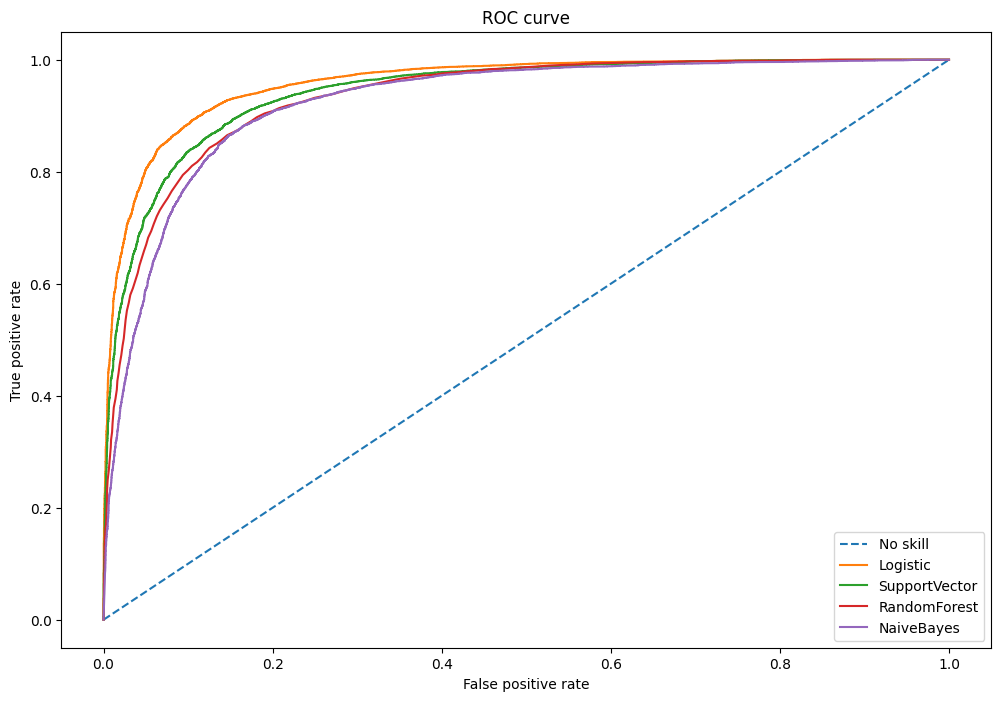

In [ ]:
no_skill_probs = [0 for _ in range(len(y_test))]
lrmod_probs = lr_model.predict_proba(X_test)[:,1]
rfmod_probs = rf_model.predict_proba(X_test)[:,1]
svmod_probs = sv_model._predict_proba_lr(X_test)[:,1]
nbmod_probs = nb_model.predict_proba(X_test)[:,1]

roc_score_lr = roc_auc_score(y_test, lrmod_probs)
roc_score_rf = roc_auc_score(y_test, rfmod_probs)
roc_score_sv = roc_auc_score(y_test, svmod_probs)
roc_score_nb = roc_auc_score(y_test, nbmod_probs)

ns_fpr, ns_tpr, _ = roc_curve(y_test, no_skill_probs)
lrmod_fpr, lrmod_tpr, _ = roc_curve(y_test, lrmod_probs)
rfmod_fpr, rfmod_tpr, _ = roc_curve(y_test, rfmod_probs)
svmod_fpr, svmod_tpr, _ = roc_curve(y_test, svmod_probs)
nbmod_fpr, nbmod_tpr, _ = roc_curve(y_test, nbmod_probs)

print("Area under the curve - Logistic: ",roc_score_lr)
print("Area under the curve - RandomForest: ",roc_score_rf)
print("Area under the curve - Support Vector: ",roc_score_sv)
print("Area under the curve - Naive Bayes: ",roc_score_nb)

plt.figure(figsize= (12,8))
plt.plot(ns_fpr, ns_tpr, linestyle= '--', label= 'No skill')
plt.plot(lrmod_fpr, lrmod_tpr, label= 'Logistic')
plt.plot(svmod_fpr, svmod_tpr, label= 'SupportVector')
plt.plot(rfmod_fpr, rfmod_tpr, label= 'RandomForest')
plt.plot(nbmod_fpr, nbmod_tpr, label= 'NaiveBayes')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc= 'lower right')

the first plot is done using

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s


Area under the curve - Logistic:  0.9589148503991792
Area under the curve - RandomForest:  0.9337190812833924
Area under the curve - Support Vector:  0.9589483618534476
Area under the curve - Naive Bayes:  0.9241007339026261


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    6.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    6.0s finished


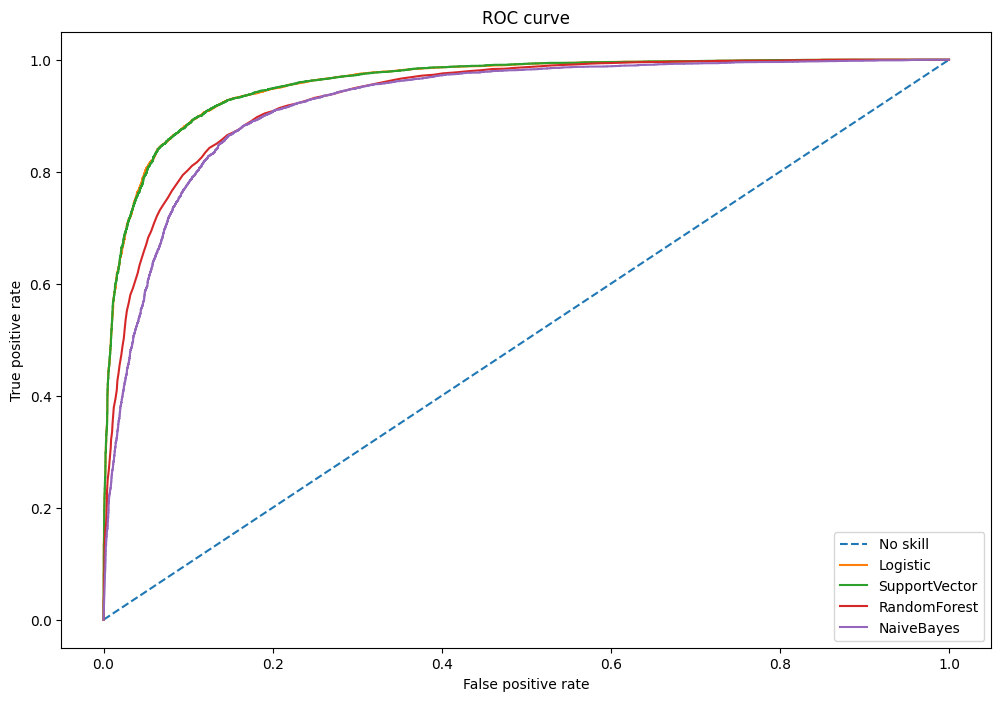

In [ ]:
no_skill_probs = [0 for _ in range(len(y_test))]
lrmod_probs = lr_model.predict_proba(X_test)[:,1]
rfmod_probs = rf_model.predict_proba(X_test)[:,1]
svmod_probs = model_svm._predict_proba_lr(X_test)[:,1]
nbmod_probs = nb_model.predict_proba(X_test)[:,1]

roc_score_lr = roc_auc_score(y_test, lrmod_probs)
roc_score_rf = roc_auc_score(y_test, rfmod_probs)
roc_score_sv = roc_auc_score(y_test, svmod_probs)
roc_score_nb = roc_auc_score(y_test, nbmod_probs)

ns_fpr, ns_tpr, _ = roc_curve(y_test, no_skill_probs)
lrmod_fpr, lrmod_tpr, _ = roc_curve(y_test, lrmod_probs)
rfmod_fpr, rfmod_tpr, _ = roc_curve(y_test, rfmod_probs)
svmod_fpr, svmod_tpr, _ = roc_curve(y_test, svmod_probs)
nbmod_fpr, nbmod_tpr, _ = roc_curve(y_test, nbmod_probs)

print("Area under the curve - Logistic: ",roc_score_lr)
print("Area under the curve - RandomForest: ",roc_score_rf)
print("Area under the curve - Support Vector: ",roc_score_sv)
print("Area under the curve - Naive Bayes: ",roc_score_nb)

plt.figure(figsize= (12,8))
plt.plot(ns_fpr, ns_tpr, linestyle= '--', label= 'No skill')
plt.plot(lrmod_fpr, lrmod_tpr, label= 'Logistic')
plt.plot(svmod_fpr, svmod_tpr, label= 'SupportVector')
plt.plot(rfmod_fpr, rfmod_tpr, label= 'RandomForest')
plt.plot(nbmod_fpr, nbmod_tpr, label= 'NaiveBayes')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc= 'lower right')

The models - LogisticRegression and SupportVector have very close Area under the curves. RandomForest comparatively underperforms. The final model chosen is the SupportVector machine as it slightly out-performs the LogisticRegression model.

In [ ]:
saved_model = open('saved_model.sav','wb')
pickle.dump(sv_model, saved_model)
saved_model.close()

In conclusion, the SupportVector model offers a good accuracy - 89% in predicting the sentiments of movie reviews from IMDB.

In [ ]:
ml_models_list = [nb_model, #Naive Bayes
                  nbm_model, #Descision Tree
                 lr_model, #Logistic Regression
                 model_svm, #Support Vector Machine
                  model_bc, #bagging classifer (base: descision tree)
                 model_stacked, #Stacked Model: NB, SVM, KNN, LR
                  rf_model, #random forestws
                  model_abc, #adaboost classifier
                  model_etc #extra trees classifier
                 ]

# Sentiment Intensity Analyzer

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
sm = SentimentIntensityAnalyzer()

In [ ]:
# polarity_Scores acually give one dictionary containing 4 values --> negative, positive, neutral and overall value
sm.polarity_scores("you are so bad")

{'neg': 0.6, 'neu': 0.4, 'pos': 0.0, 'compound': -0.6696}

In [ ]:
df.head()

,review,sentiment
0,1974 teenag martha moxley maggi grace move hig...,1
1,ok realli like kri kristofferson usual easi go...,0
2,spoiler read think watch movi wast time way pl...,0
3,hi peopl seen wonder movi im sure thet like lo...,1
4,recent bought dvd forget just hate movi versio...,0


In [ ]:
df["score"] = df["review"].apply(lambda review : sm.polarity_scores(review))

In [ ]:
df["sentiment_score"] = df["score"].apply(lambda x: x["compound"])

In [ ]:
df.head()

,review,sentiment,score,sentiment_score
0,1974 teenag martha moxley maggi grace move hig...,pos,"{'neg': 0.242, 'neu': 0.639, 'pos': 0.119, 'co...",-0.9744
1,ok realli like kri kristofferson usual easi go...,neg,"{'neg': 0.096, 'neu': 0.651, 'pos': 0.253, 'co...",0.9584
2,spoiler read think watch movi wast time way pl...,neg,"{'neg': 0.113, 'neu': 0.644, 'pos': 0.244, 'co...",0.9638
3,hi peopl seen wonder movi im sure thet like lo...,pos,"{'neg': 0.0, 'neu': 0.659, 'pos': 0.341, 'comp...",0.8979
4,recent bought dvd forget just hate movi versio...,neg,"{'neg': 0.13, 'neu': 0.673, 'pos': 0.196, 'com...",0.5574


In [ ]:
df["sentiment_score"] = df["sentiment_score"].apply(lambda x: 'pos' if x >= 0 else 'neg')

In [ ]:
df["sentiment"] = df["sentiment"].apply(lambda x: 'pos' if x == 1 else 'neg')

In [ ]:
df.head()

,review,sentiment,score,sentiment_score
0,1974 teenag martha moxley maggi grace move hig...,neg,"{'neg': 0.242, 'neu': 0.639, 'pos': 0.119, 'co...",neg
1,ok realli like kri kristofferson usual easi go...,neg,"{'neg': 0.096, 'neu': 0.651, 'pos': 0.253, 'co...",pos
2,spoiler read think watch movi wast time way pl...,neg,"{'neg': 0.113, 'neu': 0.644, 'pos': 0.244, 'co...",pos
3,hi peopl seen wonder movi im sure thet like lo...,neg,"{'neg': 0.0, 'neu': 0.659, 'pos': 0.341, 'comp...",pos
4,recent bought dvd forget just hate movi versio...,neg,"{'neg': 0.13, 'neu': 0.673, 'pos': 0.196, 'com...",pos


sent


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
def sentiment_scores(sentence):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    print("Sentiment dictionary is : ", sentiment_dict)
    print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
    print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
    print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")

    print("Sentence Overall Rated As", end = " ")

    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        print("Positive")

    elif sentiment_dict['compound'] <= - 0.05 :
        print("Negative")

    else :
        print("Neutral")

In [ ]:
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
sentence = "Average 1st half , action infused 2nd half making it overall a decent watch "

# function calling
sentiment_scores(sentence)

Sentiment dictionary is :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
sentence was rated as  0.0 % Negative
sentence was rated as  100.0 % Neutral
sentence was rated as  0.0 % Positive
Sentence Overall Rated As Neutral


In [ ]:
sentence = "Firstly the cinematography and actions were reallllyyy great with the mixture of the humourous dialogue plays"

# function calling
sentiment_scores(sentence)

Sentiment dictionary is :  {'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.8442}
sentence was rated as  0.0 % Negative
sentence was rated as  58.8 % Neutral
sentence was rated as  41.199999999999996 % Positive
Sentence Overall Rated As Positive


In [ ]:
sentence = "After a string of flops, Salman bhai is back with his much anticipated movie Tiger 3 which is from the famous tiger franchise and also the fifth installment of YRF Spy Universe!"

# function calling
sentiment_scores(sentence)

Sentiment dictionary is :  {'neg': 0.085, 'neu': 0.915, 'pos': 0.0, 'compound': -0.4003}
sentence was rated as  8.5 % Negative
sentence was rated as  91.5 % Neutral
sentence was rated as  0.0 % Positive
Sentence Overall Rated As Negative


In [ ]:
sentence = "A PERFECT movie to watch with family. Bang on!"

# function calling
sentiment_scores(sentence)

Sentiment dictionary is :  {'neg': 0.0, 'neu': 0.597, 'pos': 0.403, 'compound': 0.6932}
sentence was rated as  0.0 % Negative
sentence was rated as  59.699999999999996 % Neutral
sentence was rated as  40.300000000000004 % Positive
Sentence Overall Rated As Positive


In [ ]:
sentence = "Movie is bad."

# function calling
sentiment_scores(sentence)

Sentiment dictionary is :  {'neg': 0.636, 'neu': 0.364, 'pos': 0.0, 'compound': -0.5423}
sentence was rated as  63.6 % Negative
sentence was rated as  36.4 % Neutral
sentence was rated as  0.0 % Positive
Sentence Overall Rated As Negative


In [ ]:
sentence = "Movie is very bad."

# function calling
sentiment_scores(sentence)

Sentiment dictionary is :  {'neg': 0.558, 'neu': 0.442, 'pos': 0.0, 'compound': -0.5849}
sentence was rated as  55.800000000000004 % Negative
sentence was rated as  44.2 % Neutral
sentence was rated as  0.0 % Positive
Sentence Overall Rated As Negative


In [ ]:
sentence = "Movie is not good."

# function calling
sentiment_scores(sentence)

Sentiment dictionary is :  {'neg': 0.445, 'neu': 0.555, 'pos': 0.0, 'compound': -0.3412}
sentence was rated as  44.5 % Negative
sentence was rated as  55.50000000000001 % Neutral
sentence was rated as  0.0 % Positive
Sentence Overall Rated As Negative


In [ ]:
sentence = "Worst movie of the year."

# function calling
sentiment_scores(sentence)

Sentiment dictionary is :  {'neg': 0.506, 'neu': 0.494, 'pos': 0.0, 'compound': -0.6249}
sentence was rated as  50.6 % Negative
sentence was rated as  49.4 % Neutral
sentence was rated as  0.0 % Positive
Sentence Overall Rated As Negative
